# Sentinel

The aim of this notebook is to guide you how to get Very High Resolution Satellite (VHRS) data using Sentinelhub and predfin. Price for commercial data is described there https://www.sentinel-hub.com/pricing/.

The workflow for agriculture purposes is as follows :

1) Read shapefile that represent you field (boundaries or microplots)

2) Extract Sentinel-2 data and compute averaged NDVI time series to get a summary of the season vegetation dynamic.

2) Extract Sentinel-1 data and apply multitemporal speckle filtering

## Set your working environment

### Import the packages

In [176]:
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
from scipy.signal import savgol_filter

import os
import numpy as np
import matplotlib.pyplot as plt
from eolearn.core import FeatureType

from eocrops.input import utils_sh as utils_sh
from eocrops.input import sentinel1 as sentinel1
from eocrops.input import sentinel2 as sentinel2
from eocrops.tasks import cmd_otb as cmd_otb
from eocrops.tasks import preprocessing as preprocessing


### Read your vector file

In [162]:
dir_path = os.path.dirname(os.getcwd())
print(dir_path)
#read microplot data
shapefile_input = gpd.read_file(os.path.join(dir_path, './examples/layers/POLYGON.shp'))

/home/s999379/git-repo/eo-crops


In [163]:
api =''
client_id =''
client_secret =''
config = utils_sh.config_sentinelhub_cred(api, client_id, client_secret)
#Provide here your planet API key 
config.planet_key = ''

In [71]:
kwargs = dict(polygon=shapefile_input,
              time_stamp=time_period,
              config=config)

## Extract S2 data

In [165]:
patch = sentinel2.workflow_instructions_S2L2A(**kwargs,
                                              path_out = None, #you can specify here a path to save the EOPatch object
                                              coverage_predicate=0.5,
                                              interpolation={'interpolate' : True,
                                                             'period_length' : 8})  # you can add period_length in the dictionary to resample


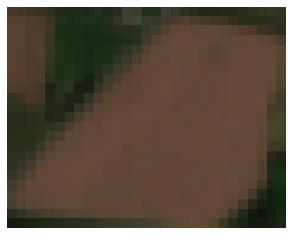

In [166]:
#RGB
plt.figure(figsize=(5, 5))
plt.imshow(np.clip(patch.data['BANDS-S2-L2A'][25][..., [2, 1, 0]]*2.5, 0, 1), vmin=0, vmax=1);
plt.axis(False);
plt.show()

In [171]:
masking = preprocessing.MaskPixels(["NDVI"])
patch = masking.execute(patch, erosion = 1)

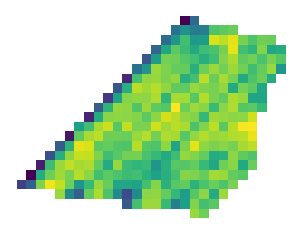

In [172]:
#NDVI
plt.figure(figsize=(5, 5))
plt.imshow(patch.data['NDVI'][15].squeeze());
plt.axis(False);
plt.show()

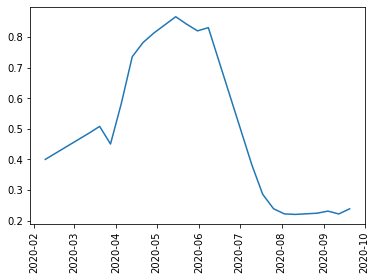

In [224]:
#LAI Time Series from masked field
variable = 'NDVI'
stats_df = preprocessing.get_time_series_profile(patch = patch, 
                                                 variable = variable, 
                                                 mask_name = 'MASK', 
                                                 function = np.nanmean)

plt.plot(patch.timestamp, stats_df[variable])
plt.xticks(rotation=90)
plt.show()

In [183]:
#Peak of the season is at 31/05 
time_argmax = np.nanargmax(stats_df[variable])
patch.timestamp[time_argmax]

datetime.datetime(2020, 5, 31, 0, 0)

## Extract Sentinel-1 data 

In [214]:
s1_eopatch = sentinel1.workflow_instructions_S1IW(**kwargs,
                                                  speckle_lee_window = 3,
                                                  orbit_direction = 'ASC',
                                                  backCoeff = 'SIGMA0_ELLIPSOID' )  # you can add period_length in the dictionary to resample

In [215]:
VV = s1_eopatch.data['BANDS-S1-IW'][...,0]
VH =  s1_eopatch.data['BANDS-S1-IW'][...,1]
RVI = (4*VH)/(VH+VV)
s1_eopatch.add_feature(FeatureType.DATA, "RVI", RVI[..., np.newaxis])
masking = preprocessing.MaskPixels([ "RVI"])
s1_eopatch = masking.execute(s1_eopatch)

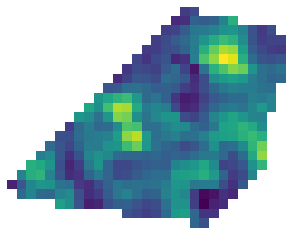

In [216]:
#Display RVI from SIGMA0 without any speckle filtering
s1_eopatch = masking.execute(s1_eopatch)
plt.figure(figsize=(5, 5))
plt.imshow(s1_eopatch.data['RVI'][25,].squeeze());
plt.axis(False);
plt.show()

You can easily download and install OTB https://www.orfeo-toolbox.org/CookBook/Installation.html#linux, which allows you to apply Quegan multitemporal speckle filtering

In [217]:
#Can take around 30 seconds
mutlitemp = cmd_otb.MultitempSpeckleFiltering(otb_path = '/home/s999379/git-repo/OTB-7.4.0-Linux64/bin',
                                             window = 3)
s1_eopatch = mutlitemp.execute(s1_eopatch)

In [220]:
VH = s1_eopatch.data['VH_filtered']
VV = s1_eopatch.data['VV_filtered']
RVI_smoothed = (4*VH)/(VH+VV)
s1_eopatch.add_feature(FeatureType.DATA, "RVI_smoothed", RVI_smoothed)
masking = preprocessing.MaskPixels(["RVI_smoothed"])
s1_eopatch = masking.execute(s1_eopatch)

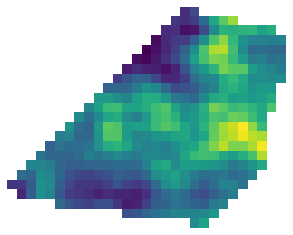

In [222]:
plt.figure(figsize=(5, 5))
plt.imshow(s1_eopatch.data['RVI_smoothed'][25,].squeeze().squeeze());
plt.axis(False);
plt.show()

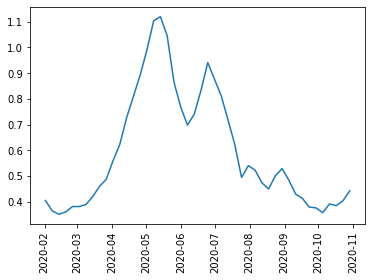

In [223]:
#LAI Time Series from masked field
variable = 'RVI_smoothed'
stats_df = preprocessing.get_time_series_profile(patch = s1_eopatch, 
                                                 variable = variable, 
                                                 mask_name = 'MASK', 
                                                 function = np.nanmean)
smoothed_rvi =  savgol_filter(stats_df[variable], 5 , 2)
plt.plot(s1_eopatch.timestamp, smoothed_rvi)
plt.xticks(rotation=90)
plt.show()